## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [3]:
stock_symbol = "GOOGL" # GOOGLE
stock_data = yf.download(stock_symbol, start="2020-01-01", end="2023-12-31")

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.264961,27278000
2020-01-03,67.400002,68.687500,67.365997,68.075996,67.907845,23408000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.717865,46768000
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.583206,34330000
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.078476,35314000
...,...,...,...,...,...,...
2023-12-22,140.770004,141.990005,140.710007,141.490005,141.140518,26514600
2023-12-26,141.589996,142.679993,141.190002,141.520004,141.170441,16780300
2023-12-27,141.589996,142.080002,139.889999,140.369995,140.023270,19628600


### Column 설명

- Date: 거래가 이루어진 날짜
- Open: 해당 거래일의 시초가로, 거래가 시작될 때 주식의 가격
- High: 해당 거래일 동안의 최고가로, 주식이 거래된 하루 중 가장 높았던 가격
- Low: 해당 거래일 동안의 최저가로, 하루 중 가장 낮았던 가격
- Close: 해당 거래일의 종가로, 거래가 종료될 때의 주식 가격
- Adj Close: 수정 종가로 배당이나 주식 분할 등으로 인해 조정된 종가
- Volume: 해당 거래일 동안의 거래량으로, 거래된 주식의 총 수량

1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [6]:
stock_data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [7]:
# 제거할 결측치 없음

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [8]:
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.sort_index()

stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.264961,27278000
2020-01-03,67.400002,68.687500,67.365997,68.075996,67.907845,23408000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.717865,46768000
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.583206,34330000
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.078476,35314000
...,...,...,...,...,...,...
2023-12-22,140.770004,141.990005,140.710007,141.490005,141.140518,26514600
2023-12-26,141.589996,142.679993,141.190002,141.520004,141.170441,16780300
2023-12-27,141.589996,142.080002,139.889999,140.369995,140.023270,19628600


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

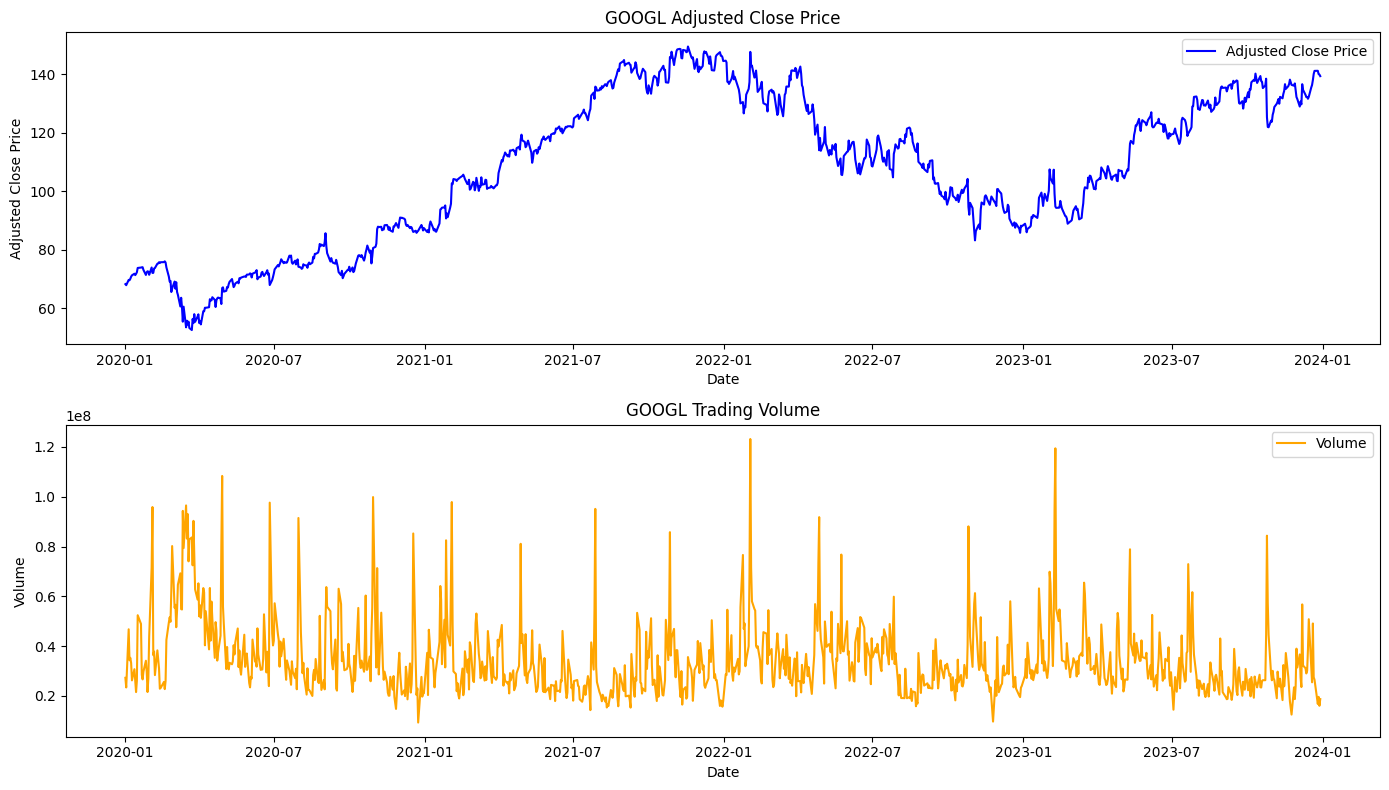

In [10]:
plt.figure(figsize=(14, 8))

# 수정종가
plt.subplot(2, 1, 1)
plt.plot(stock_data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.title(f'{stock_symbol} Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()

# 거래량
plt.subplot(2, 1, 2)
plt.plot(stock_data['Volume'], label='Volume', color='orange')
plt.title(f'{stock_symbol} Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

- 수정종가 추세: COVID-19 이후 상승세를 보였으나 2022년 초 하락 전환 후 2023년부터 회복세입니다.

- 거래량 패턴: 팬데믹 초기와 주요 변동 시기에 거래량이 급증했으나 최근으로 갈수록 감소하는 추세입니다.

- 수정종가와 거래량 관계: 주가 급변 시 거래량이 함께 증가하며, 안정 구간에서는 거래량이 낮은 경향을 보입니다.
    - 안정 구간: 주가가 큰 변동 없이 일정 범위 내에서 유지되며 거래량이 낮아지는 기간

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

정상성은 시계열 데이터가 시간에 따라 평균과 분산이 변하지 않는 성질입니다. 정상성은 정확한 예측을 위해 필요하며, 이를 만족하지 않으면 차분, 로그 변환, 계절성 조정 등의 방법으로 해결할 수 있습니다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(stock_data['Adj Close'].dropna())

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -1.520830400848377
p-value: 0.5231828285638674


2.3 ADF Test 결과를 해석하세요.

p-value가 0.05보다 크기 때문에, 이 결과는 귀무가설을 기각할 수 없음을 의미합니다. ADF 테스트의 귀무가설은 `데이터가 비정상성을 가진다`이므로, 귀무가설을 기각하지 못하는 경우 데이터가 정상성을 가지지 않는다는 결론을 내릴 수 있습니다.

따라서, 수정 종가는 비정상성을 가지고 있으며, 차분이나 로그 변환 같은 방법을 사용하여 정상성을 확보해야 예측 모델에 적용하기 적합합니다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF는 전체 상관관계를, PACF는 특정 시차에 대한 순수한 상관관계를 나타냅니다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

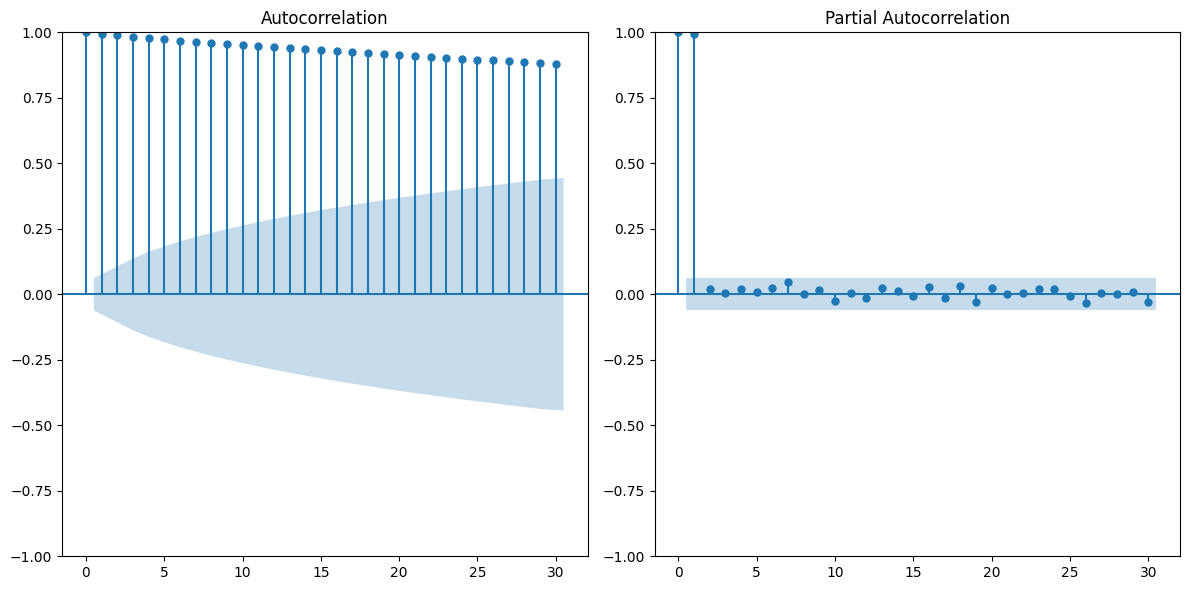

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(stock_data['Adj Close'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(stock_data['Adj Close'].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

- ACF
    - ACF 그래프에서 모든 시차에 걸쳐 높은 양의 상관관계가 나타나고 있습니다. 이는 데이터가 비정상성을 가지고 있으며, 시계열 내에서 강한 자기상관성이 존재함을 의미합니다.
    - 정상적인 시계열 데이터라면 특정 시차 이후로 상관관계가 급격히 감소해야 하지만, 여기서는 시차가 커져도 상관관계가 지속되는 패턴이 보입니다.

- PACF
    - PACF 그래프는 시차 1에서 높은 상관관계를 보이지만, 이후 대부분의 시차에서 상관관계가 유의하지 않습니다. 이는 자기회귀(AR) 모델의 적절한 차수를 파악하는 데 도움을 주며, 시차 1의 자기회귀 항이 유효함을 나타냅니다.
    - 이 패턴은 AR(1) 모델이 적합할 수 있음을 시사합니다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

<Figure size 1000x800 with 0 Axes>

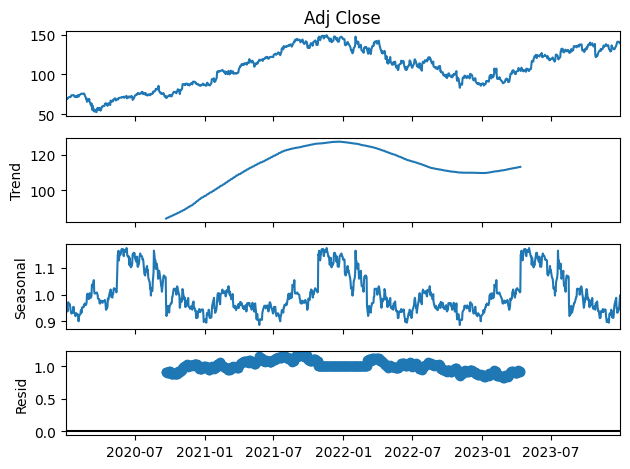

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Adj Close'], model='multiplicative', period=365)

plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

2.8 위 결과를 해석하세요.

1. Adj Close(수정종가)
- 전체적으로 2020년부터 2023년까지 상승과 하락의 패턴이 반복되고 있습니다.

2. 데이터의 추세
- 장기적인 상승과 하락 경향을 보여주며, 2020년 중반부터 주가가 상승하다가 2022년에 최고점에 도달한 후 완만하게 하락하는 추세를 보입니다.

3. 계절성
-  주가가 일정한 주기를 따라 오르내리는 경향을 확인할 수 있습니다.

4. 잔차
- 평균에 가까운 일정한 분포를 보이고 있습니다. 이는 추세와 계절성을 제거한 후 남은 데이터가 평균을 중심으로 작은 변동을 가지며, 큰 이상치는 보이지 않는다는 것을 의미합니다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분은 시계열 데이터의 비정상성을 해결하기 위해 사용되는 기법으로, 이전 시점의 데이터 값과 현재 시점의 데이터 값의 차이를 계산하여 새로운 시계열을 만드는 방법입니다. 차분을 통해 데이터의 평균과 분산을 일정하게 만들어 정상성을 확보할 수 있으며, 시계열의 추세를 제거하여 변동성을 줄이는 데 효과적입니다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [14]:
from statsmodels.tsa.stattools import adfuller

stock_data['Adj Close_diff'] = stock_data['Adj Close'].diff()
adf_result = adfuller(stock_data['Adj Close_diff'].dropna())

print(f"ADF Statistic (Differenced): {adf_result[0]}")
print(f"p-value (Differenced): {adf_result[1]}")

# 정상성 여부 판단
if adf_result[1] < 0.05:
    print("차분 후 데이터가 정상성을 가집니다.")
else:
    print("차분 후에도 데이터가 정상성을 가지지 않습니다.")

ADF Statistic (Differenced): -33.15516637548189
p-value (Differenced): 0.0
차분 후 데이터가 정상성을 가집니다.


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

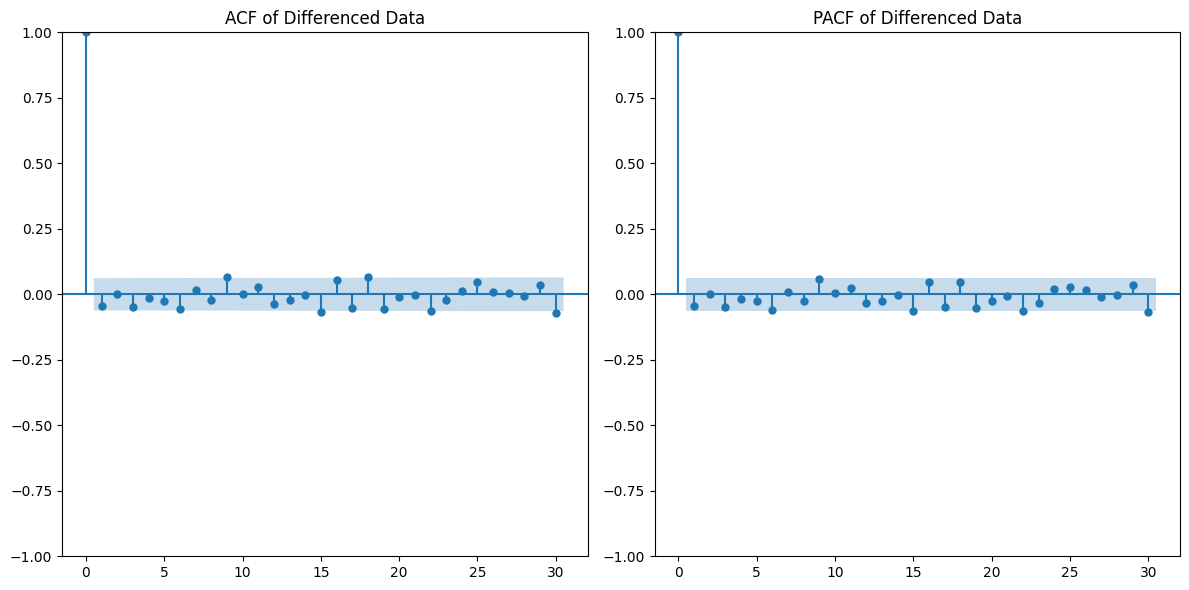

In [15]:
differenced_data = stock_data['Adj Close_diff'].dropna()

plt.figure(figsize=(12, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(differenced_data, lags=30, ax=plt.gca())
plt.title('ACF of Differenced Data')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(differenced_data, lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF of Differenced Data')

plt.tight_layout()
plt.show()

-> ACF와 PACF 모두 첫 번째 시차에서 높은 상관을 보이고, 이후의 시차에서는 큰 상관이 없는 패턴을 나타내고 있습니다.

<Figure size 1000x800 with 0 Axes>

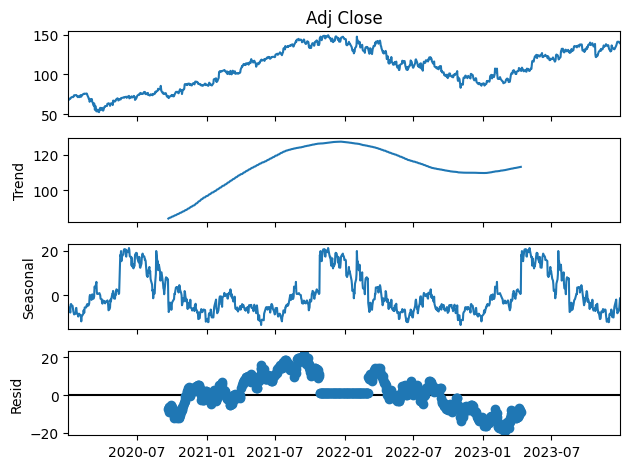

In [16]:
decomposition = seasonal_decompose(stock_data['Adj Close'].dropna(), model='additive', period=365)

plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

-> 나머지는 앞의 그래프와 비슷하고, 잔차가 0을 중심으로 분포하지 않고, 특히 2021년 중반 이후로 큰 변동을 보여주며, 특정 패턴이 나타나고 있습니다. 잔차에 이러한 변동이 있다면, 모델이 데이터의 모든 변동을 완전히 설명하지 못했을 가능성이 있으며, 추가적인 외부 요인이나 비정상성이 존재할 수 있습니다.

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
stock_data['Adj Close_diff']

,Adj Close_diff
Date,
2020-01-02,NaN
2020-01-03,-0.357117
2020-01-06,1.810020
2020-01-07,-0.134659
2020-01-08,0.495270
...,...
2023-12-22,1.067368
2023-12-26,0.029922
2023-12-27,-1.147171


`order=(p, d, q)`
- p: AR(Auto-Regressive) 부분의 차수. 3으로 설정하면, 이전 3개의 시차가 현재 값에 영향을 준다고 가정합니다.
- d: I(Integrated) 부분의 차수. 이미 차분된 데이터를 사용하고 있는 경우, d=0으로 설정합니다.
- q: MA (Moving Average) 부분의 차수를 의미합니다. 여기서는 이동 평균 요소를 포함하지 않기 위해 0으로 설정하였습니다.

In [19]:
model = ARIMA(stock_data['Adj Close_diff'], order=(3, 0, 0)) 
model_fit = model.fit()


model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1006
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2193.797
Date:                Tue, 08 Oct 2024   AIC                           4397.595
Time:                        11:07:39   BIC                           4422.164
Sample:                             0   HQIC                          4406.930
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0708      0.062      1.135      0.256      -0.051       0.193
ar.L1         -0.0463      0.027     -1.705      0.088      -0.100       0.007
ar.L2         -0.0027      0.029     -0.092      0.926      -0.061       0.055
ar.L3         -0.0470      0.026     -1.790      0.073      -0.098       0.004
sigma2         4.6084      0.133     34.718      0.000       4.348       4.869
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               388.85
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


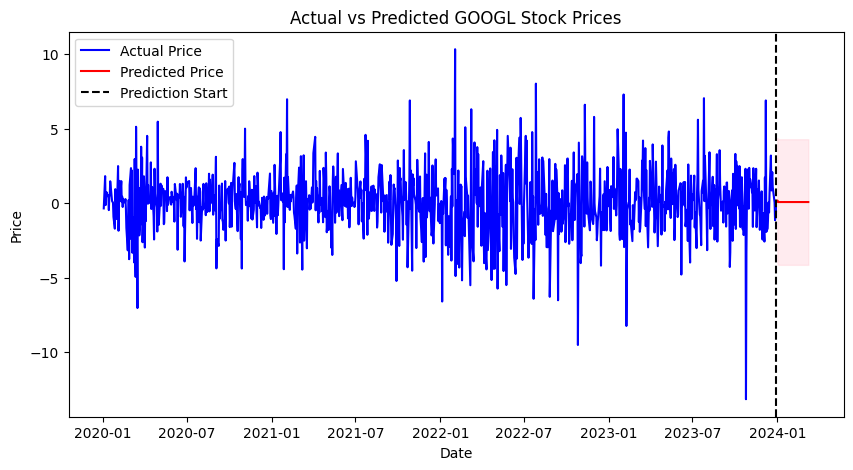

In [20]:
# 예측 수행(50일)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(stock_data.index, stock_data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=stock_data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=stock_data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=stock_data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title(f'Actual vs Predicted {stock_symbol} Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(stock_symbol, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%***********************]  1 of 1 completed


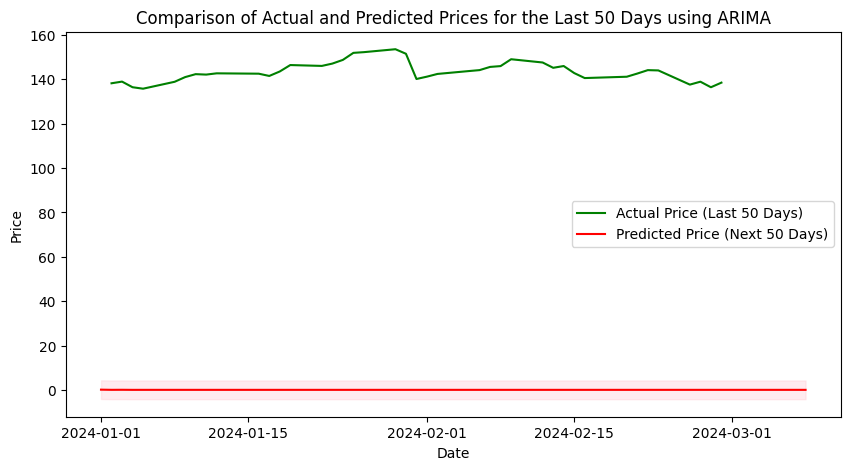

In [22]:
# 실제 데이터와 예측 결과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=stock_data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Next 50 Days)', color='red')
plt.fill_between(pd.date_range(start=stock_data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [23]:
from prophet import Prophet

In [24]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'GOOGL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%***********************]  1 of 1 completed


In [25]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnx4j9zk/yhj9re63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnx4j9zk/gr146v_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19914', 'data', 'file=/tmp/tmpfnx4j9zk/yhj9re63.json', 'init=/tmp/tmpfnx4j9zk/gr146v_t.json', 'output', 'file=/tmp/tmpfnx4j9zk/prophet_modeloq5hee6x/prophet_model-20241008111634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:16:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:16:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [26]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

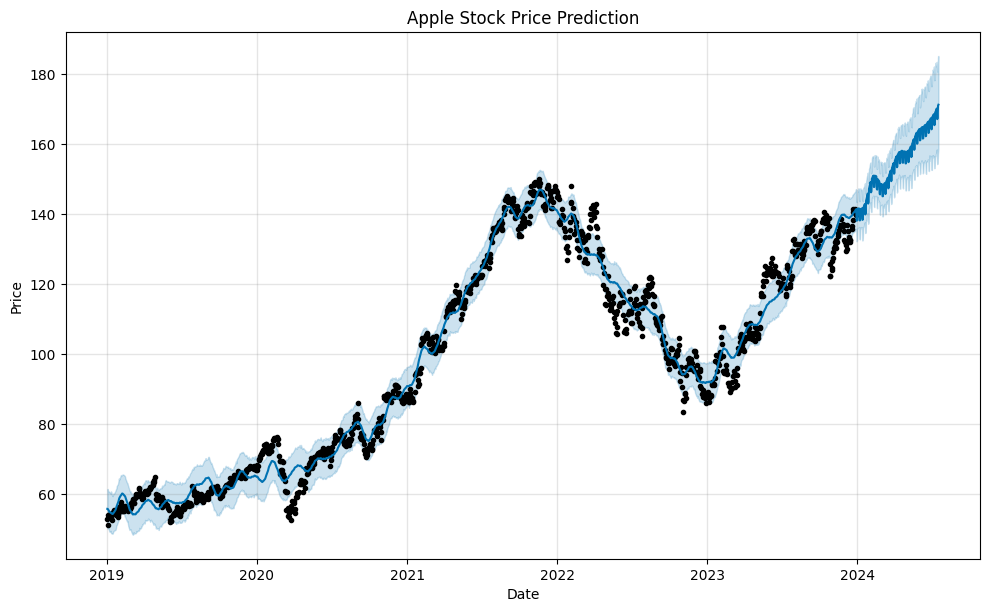

In [27]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

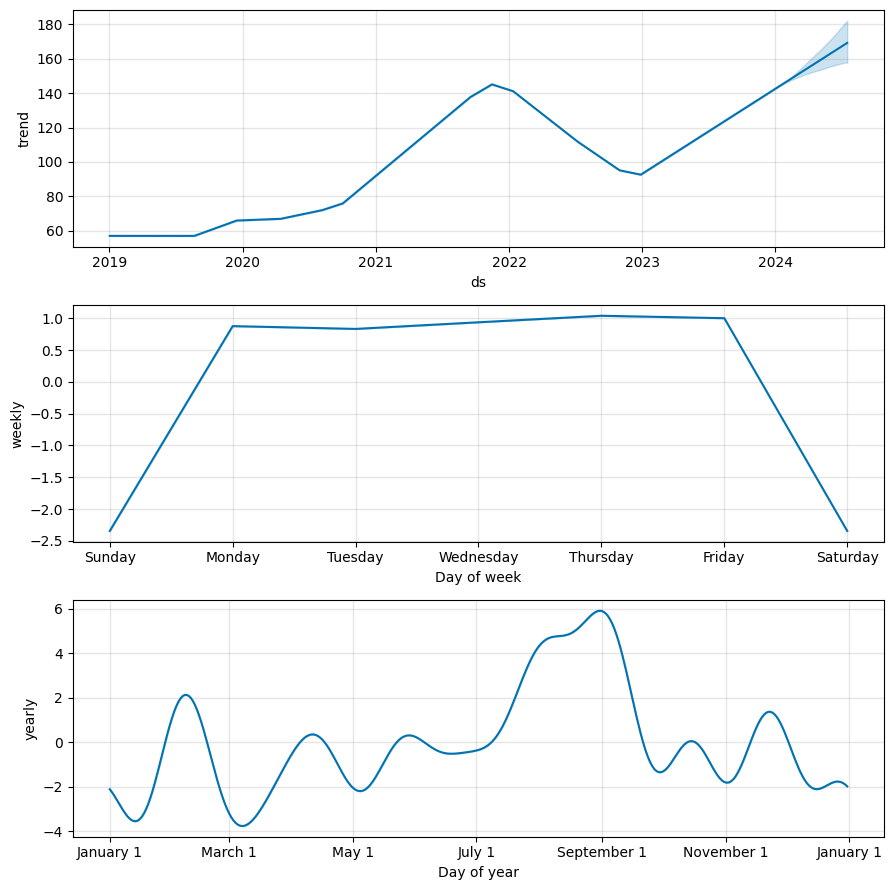

In [28]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [29]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


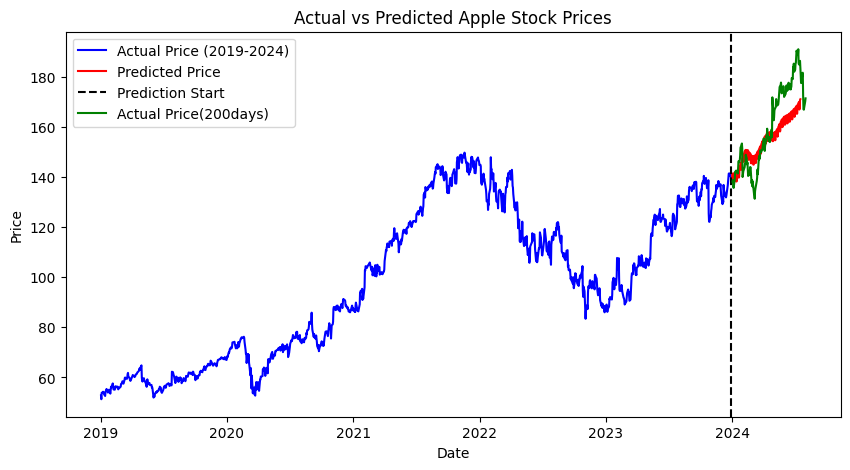

In [30]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [32]:
ticker = 'GOOGL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


In [35]:
model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnx4j9zk/wtvx4yei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnx4j9zk/kp5p_afx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69857', 'data', 'file=/tmp/tmpfnx4j9zk/wtvx4yei.json', 'init=/tmp/tmpfnx4j9zk/kp5p_afx.json', 'output', 'file=/tmp/tmpfnx4j9zk/prophet_modelk17i4kas/prophet_model-20241008111915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

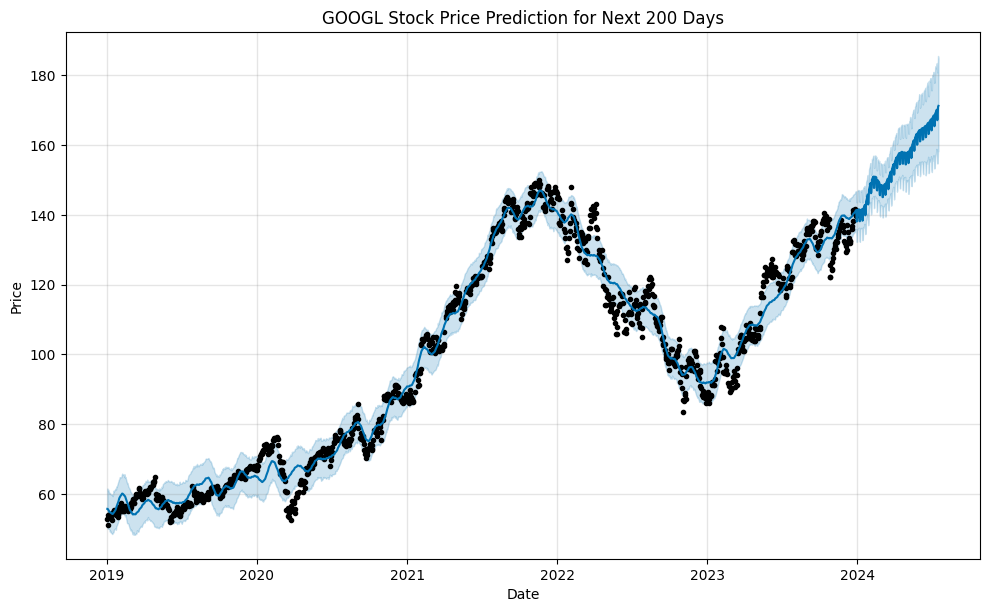

In [36]:
plt.figure(figsize=(10, 5))
model.plot(forecast)
plt.title(f'{ticker} Stock Price Prediction for Next 200 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 구성요소 
- 검은색 점: 과거 실제 주가 데이터를 나타냅니다. GOOGL 주식의 조정 종가가 시간이 지남에 따라 어떻게 변동했는지를 보여줍니다.
- 파란색 선: 예측된 주가를 나타냅니다. ARIMA 모델 등의 시계열 예측 모델을 사용하여 향후 200일 동안의 주가를 예측한 값입니다.
- 파란색 음영 영역: **예측 구간(Confidence Interval)**을 나타냅니다. 예측값이 이 구간 내에 있을 확률을 나타내며, 보통 95% 신뢰 구간으로 설정됩니다. 음영이 넓을수록 예측의 불확실성이 크다는 의미입니다.

### 결과 해석
- 2023년을 지나면서 주가가 회복세를 보였고, 2024년엣는 상승세가 지속될 것 으로 예측됩니다. 
- 예측 기간이 길어질수록 구간이 넓어지고 있습니다. 이는 시간이 지남에 따라 예측의 불확실성이 증가한다는 것을 의미합니다.
- 예측 결과가 신뢰 구간 내에서 변동하고 있으므로, 모델이 주가의 전반적인 방향성을 잘 포착하고 있다고 볼 수 있습니다.

-> 이 예측 그래프는 GOOGL 주식의 향후 200일 동안의 가격이 상승할 가능성을 시사합니다.

In [38]:
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]

forecast_last_50 = forecast.set_index('ds').loc[actual_last_50.index]['yhat']

y_true = actual_last_50['Close'].values  # 실제 값 (마지막 50일)
y_pred = forecast_last_50.values  # 예측 값 (마지막 50일 예측)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

[*********************100%***********************]  1 of 1 completed

RMSE: 5.93198308625377
MAE: 5.071716215921518


-> 이 평가 결과는 예측 모델이 마지막 50일간의 GOOGLE 주가에 대해 평균적으로 5~6의 오차 범위 내에서 예측했다는 것을 보여줍니다.

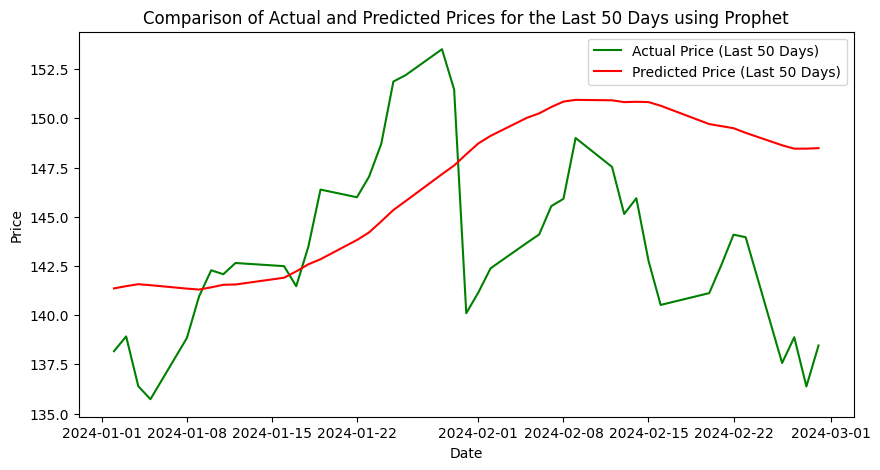

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(forecast_last_50.index, forecast_last_50, label='Predicted Price (Last 50 Days)', color='red')
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using Prophet')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

- 초록색 선: 마지막 50일 동안의 실제 주가를 나타냅니다.
- 빨간색 선: Prophet 모델이 예측한 마지막 50일 동안의 주가를 나타냅니다.

-> 이 그래프는 Prophet 모델이 전체적인 주가의 방향성이나 추세는 대체로 잘 맞췄지만, 급격한 상승과 하락과 같은 비정상적 변동성은 예측에 어려움을 겪고 있음을 보여줍니다.